# Algorithm Selection

@roman

21 July, 2024

In [1]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import shap

from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.stats import hmean
from INEGIpy import MarcoGeoestadistico

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Settings
# show 100 columns in pandas
pd.set_option('display.max_columns', 500)
TODAY = pd.to_datetime('today')
# inegi class
inegi_api = MarcoGeoestadistico()

---
# Data

## Mexico Shape

<Axes: >

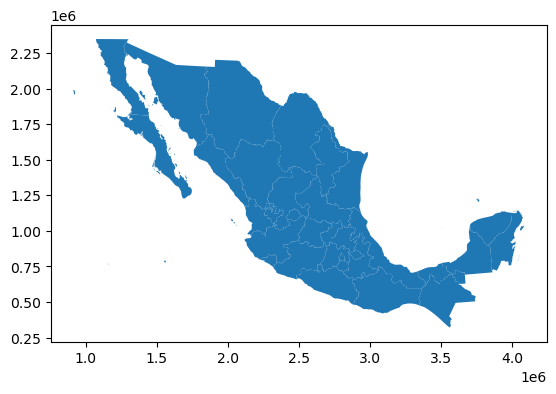

In [3]:
# read country shape
gdf_mexico = inegi_api.Entidades()

# change crs to 6372
gdf_mexico = gdf_mexico.to_crs(epsg=6372)
gdf_mexico.plot()

## Read

In [4]:
def get_properties_data(file_path, cols_to_stay, cols_as_categories):
    # Read database
    df = pd.read_parquet(file_path)

    # Set property_id as index
    df = df.set_index('property_id')

    # Handling NaNs
    df['elevador'] = df['elevador'].fillna(0)
    df['cve_vigilancia'] = df['cve_vigilancia'].fillna(0)
    df['tipo_vialidad'] = df['tipo_vialidad'].fillna(0)

    # Fill missing competitors values with terrain values
    df['competitors_weighted_mean_log_price_per_sqm'] = df['competitors_weighted_mean_log_price_per_sqm'].combine_first(df['mean_log_valor_fisico_terreno_m2'])
    df['competitors_weighted_mean_log_price_per_sqm_lower'] = df['competitors_weighted_mean_log_price_per_sqm_lower'].combine_first(df['mean_log_valor_fisico_terreno_m2_lower'])
    df['competitors_weighted_mean_log_price_per_sqm_upper'] = df['competitors_weighted_mean_log_price_per_sqm_upper'].combine_first(df['mean_log_valor_fisico_terreno_m2_upper'])

    # Casting integer columns
    columns_to_integer = ['cve_vigilancia', 'tipo_vialidad']
    df[columns_to_integer] = df[columns_to_integer].astype('float').round().astype('Int64')

    # Feature Engineering
    first_date_obs = df['fecha_avaluo'].min()
    last_date_obs = df['fecha_avaluo'].max()

    df = (
        df
        .assign(
            year_appraised=lambda x: x['fecha_avaluo'].dt.year,
            price_per_sqm=lambda x: x['valor_mercado'] / x['superficie_vendible'],
            quarters_since_first_appraisal=lambda x: (x['fecha_avaluo'] - first_date_obs).dt.days / (30.4 * 3),
            conservacion_recat=lambda x: x['conservacion'].replace({7: 3.5}) - x['conservacion'].min(),
            cve_vigilancia_recat=lambda x: np.where(x['cve_vigilancia'].eq(2), 1, 0),
            superficie_terreno_usable=lambda x: np.where(
                x['id_tipo_inmueble'].eq(4),
                x['superficie_accesoria'],
                x['superficie_terreno'] + x['superficie_accesoria']
            ),
            elevador=lambda x: x['elevador'].eq(1).astype('int'),
        )
    )

    # Cast columns as categories
    df[cols_as_categories] = df[cols_as_categories].astype('category')

    return df.loc[:, cols_to_stay]

# get data
cols_to_stay_with = [
    'id_clase_inmueble',
    'property_type',
    'elevador',
    'edad_anios',
    'year_appraised',
    'regimen_propiedad',
    'id_entidad_f',
    'banos',
    'medio_banos',
    'estacionamiento',
    'superficie_vendible',
    'superficie_terreno_usable',
    'distance_to_ocean',
    'longitud',
    'latitud',
    'count_supermarkets_at_1km',
    'count_hospitals_at_5km',
    'count_metro_at_1km',
    'count_schools_at_1km',
    'count_restaurants_at_1km',
    'competitors_weighted_mean_log_price_per_sqm',
    'mean_log_valor_fisico_terreno_m2',
    'mean_log_valor_fisico_terreno_m2_lower',
    'mean_log_valor_fisico_terreno_m2_upper',
    'quarters_since_first_appraisal',
    'conservacion_recat',
    'cve_vigilancia_recat',
    'price_per_sqm',
]

cols_to_categories = [
    'property_type', 'cve_vigilancia_recat', 'regimen_propiedad', 'id_entidad_f', 
]

df_properties = get_properties_data(
    "../../data/clean/properties_shif.parquet", cols_to_stay_with, cols_to_categories
    )

# see
print(df_properties.shape)
df_properties.head()

(852913, 28)


id_clase_inmueble property_type  elevador  \
property_id                                                                   
66cf10199ef943a5a5ff82129e53d5d7                  4         house         1   
f84f9a0c784f491eab6bb100b513a95b                  3         house         0   
7ddd5a94feed4955a809f986d95722d8                  4         house         0   
d2e75fb3b385461995bf8d34b9d1fdfb                  4         house         0   
6f1194f9853443219e63f4a3222b010e                  4         house         0   

                                  edad_anios  year_appraised  \
property_id                                                    
66cf10199ef943a5a5ff82129e53d5d7          25            2020   
f84f9a0c784f491eab6bb100b513a95b          25            2020   
7ddd5a94feed4955a809f986d95722d8           1            2020   
d2e75fb3b385461995bf8d34b9d1fdfb          35            2020   
6f1194f9853443219e63f4a3222b010e          26            2020   

                                   regimen_propiedad id_entidad_f  banos  \
property_id                                                                
66cf10199ef943a5a5ff82129e53d5d7  PRIVADA INDIVIDUAL           09      1   
f84f9a0c784f491eab6bb100b513a95b  PRIVADA INDIVIDUAL           15      2   
7ddd5a94feed4955a809f986d95722d8  PRIVADA INDIVIDUAL           15      2   
d2e75fb3b385461995bf8d34b9d1fdfb  PRIVADA INDIVIDUAL           09      2   
6f1194f9853443219e63f4a3222b010e  PRIVADA INDIVIDUAL           15      1   

                                  medio_banos  estacionamiento  \
property_id                                                      
66cf10199ef943a5a5ff82129e53d5d7            0                0   
f84f9a0c784f491eab6bb100b513a95b            0                1   
7ddd5a94feed4955a809f986d95722d8            0                1   
d2e75fb3b385461995bf8d34b9d1fdfb            0                0   
6f1194f9853443219e63f4a3222b010e            0                0   

                                  superficie_vendible  \
property_id                                             
66cf10199ef943a5a5ff82129e53d5d7                  348   
f84f9a0c784f491eab6bb100b513a95b                  108   
7ddd5a94feed4955a809f986d95722d8                  170   
d2e75fb3b385461995bf8d34b9d1fdfb                  139   
6f1194f9853443219e63f4a3222b010e                   54   

                                  superficie_terreno_usable  \
property_id                                                   
66cf10199ef943a5a5ff82129e53d5d7                        143   
f84f9a0c784f491eab6bb100b513a95b                        113   
7ddd5a94feed4955a809f986d95722d8                        200   
d2e75fb3b385461995bf8d34b9d1fdfb                        107   
6f1194f9853443219e63f4a3222b010e                         84   

                                  distance_to_ocean   longitud    latitud  \
property_id                                                                 
66cf10199ef943a5a5ff82129e53d5d7                inf -99.158103  19.310875   
f84f9a0c784f491eab6bb100b513a95b                inf -99.065361  19.491722   
7ddd5a94feed4955a809f986d95722d8                inf -99.213541  19.633393   
d2e75fb3b385461995bf8d34b9d1fdfb                inf -99.114525  19.333061   
6f1194f9853443219e63f4a3222b010e                inf -99.052833  19.486586   

                                  count_supermarkets_at_1km  \
property_id                                                   
66cf10199ef943a5a5ff82129e53d5d7                          2   
f84f9a0c784f491eab6bb100b513a95b                          0   
7ddd5a94feed4955a809f986d95722d8                          1   
d2e75fb3b385461995bf8d34b9d1fdfb                          2   
6f1194f9853443219e63f4a3222b010e                          2   

                                  count_hospitals_at_5km  count_metro_at_1km  \
property_id                                                                    
66cf10199ef943a5a5ff82129e53d5d7                   

In [5]:
# count dtypes
df_properties.dtypes.value_counts()

int64       13
float64     10
category     1
int32        1
category     1
category     1
category     1
Name: count, dtype: int64

In [6]:
# see nans
df_properties.isna().sum()[df_properties.isna().sum() > 0]

Series([], dtype: int64)

## Split

In [7]:
# split data (index)
index_train, index_test = train_test_split(
    df_properties.index, test_size=0.1, random_state=42, stratify=df_properties['property_type']
    )

# sizes
print(f"Train size: {len(index_train)}")
print(f"Test size: {len(index_test)}")

Train size: 767621
Test size: 85292


In [8]:
# count of property types
df_properties.loc[index_train, 'property_type'].value_counts(normalize=True)

property_type
house        0.756896
apartment    0.243104
Name: proportion, dtype: float64

In [9]:
# count of property types
df_properties.loc[index_test, 'property_type'].value_counts(normalize=True)

property_type
house        0.756894
apartment    0.243106
Name: proportion, dtype: float64

---
# Models

In [10]:
def calculate_metrics(y, y_pred, best_percent=1.0):
    # Create a DataFrame to hold y, y_pred, and MAPE
    df = pd.DataFrame({
        'y': y,
        'y_pred': y_pred
    })
    
    # Calculate MAPE
    df['mape'] = np.abs((df['y'] - df['y_pred']) / df['y'])
    
    # Determine the threshold MAPE to filter the best_percent data
    threshold_mape = df['mape'].quantile(best_percent)
    
    # Filter the best_percent of the data
    df_best = df[df['mape'] <= threshold_mape]
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(df_best['y'], df_best['y_pred']))
    mae = mean_absolute_error(df_best['y'], df_best['y_pred'])
    mape_best = df_best['mape'].mean()
    r2 = r2_score(df_best['y'], df_best['y_pred'])
    
    return pd.Series({
        "rmse": rmse,
        "mape": mape_best,
        "mae": mae,
        "r2": r2
    })

## XGBoost (got stucked in the time consuming of dmatrx)

### Fit

In [11]:
# # cols to use
# cols_x = [
#     'id_clase_inmueble', 
#     # 'property_type',
#     'elevador', 'edad_anios',
#     # 'regimen_propiedad', 'id_entidad_f', 'banos',
#     # 'medio_banos', 'estacionamiento', 'superficie_vendible',
#     # 'superficie_terreno_usable', 'distance_to_ocean', 'longitud', 'latitud',
#     # 'count_supermarkets_at_1km', 'count_hospitals_at_5km',
#     # 'count_metro_at_1km', 'count_schools_at_1km',
#     # 'count_restaurants_at_1km',
#     # 'competitors_weighted_mean_log_price_per_sqm',
#     # 'mean_log_valor_fisico_terreno_m2',
#     # 'mean_log_valor_fisico_terreno_m2_lower',
#     # 'mean_log_valor_fisico_terreno_m2_upper',
#     # 'quarters_since_first_appraisal', 'conservacion_recat',
#     # 'cve_vigilancia_recat'
# ]

# # categorical_cols = [
# #     'property_type', 'cve_vigilancia_recat', 'regimen_propiedad', 'id_entidad_f'
# # ]

# # x_train, y_train
# X_train = df_properties.loc[index_train, cols_x].copy()
# y_train = df_properties['price_per_sqm'].loc[index_train].copy()

# # x_test, y_test
# X_test = df_properties.loc[index_test, cols_x].copy()
# y_test = df_properties['price_per_sqm'].loc[index_test].copy()

# # one hot categorical cols
# # X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True, dtype='int')
# # X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True, dtype='int')

# # # distance to ocean: from inf to 100_000
# # X_train['distance_to_ocean'] = X_train['distance_to_ocean'].replace(np.inf, 100_000)
# # X_test['distance_to_ocean'] = X_test['distance_to_ocean'].replace(np.inf, 100_000)

# # set all columns as float
# X_train = X_train.astype('float')
# X_test = X_test.astype('float')

# # see num cols
# print(X_train.shape)
# print(X_test.shape)

In [12]:
# # generate dmatrix
# # dtrain = xgb.DMatrix(X_train, label=y_train)
# # dtest = xgb.DMatrix(X_test, label=y_test)

In [13]:
# params = {
#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse',
#     'max_depth': 6,
#     'eta': 0.01,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8,
#     'enable_categorical': True,
#     'seed': 42,
#     'nthread': 4,
#     'early_stopping_rounds': 50,
#     'n_estimators': 1000,
#     'verbose': 1
# }


# # Train the model
# xgb_model = xgb.XGBRegressor(**params)
# xgb_model.fit(
#     X_train, y_train,
#     eval_set=[(X_train, y_train), (X_test, y_test)],
# )

## Baseline Model

### Fit

In [14]:
class BaselineModel(BaseEstimator, RegressorMixin):
    def __init__(self):
        self.harmonic_means_ = {}
        self.default_mean_ = None
        self.first_category_ = None

    def fit(self, X, y):
        # Ensure X is a DataFrame and has exactly 2 columns
        if not isinstance(X, pd.DataFrame) or X.shape[1] != 2:
            raise ValueError("X must be a DataFrame with exactly 2 columns.")
        
        # Ensure y is a Series or ndarray with the same length as X
        if len(y) != len(X):
            raise ValueError("Length of y must be equal to the number of rows in X.")
        
        # Create a DataFrame with y included
        df = X.copy()
        df['y'] = y
        
        # Calculate harmonic means for each combination of categories
        grouped = df.groupby(list(X.columns))['y']
        self.harmonic_means_ = grouped.apply(lambda grp: hmean(grp)).to_dict()
        
        # Calculate the default mean as the harmonic mean of the first category
        self.first_category_ = X.columns[0]
        first_category = df.iloc[0][self.first_category_]
        
        if first_category:
            first_category_df = df[df[self.first_category_] == first_category]
            if not first_category_df.empty:
                # Calculate harmonic mean for each level of the second category
                category_means = first_category_df.groupby(X.columns[1])['y'].apply(lambda grp: hmean(grp))
                # Calculate the overall harmonic mean of these category means
                if not category_means.empty:
                    self.default_mean_ = hmean(category_means.values)
                else:
                    self.default_mean_ = np.nan
            else:
                self.default_mean_ = np.nan
        else:
            self.default_mean_ = np.nan
        
        return self

    def predict(self, X):
        # Ensure X is a DataFrame and has exactly 2 columns
        if not isinstance(X, pd.DataFrame) or X.shape[1] != 2:
            raise ValueError("X must be a DataFrame with exactly 2 columns.")
        
        # Create a DataFrame for predictions
        X_copy = X.copy()
        X_copy['prediction'] = X_copy.apply(lambda row: self.harmonic_means_.get(tuple(row), self.default_mean_), axis=1)
        return X_copy['prediction'].values


In [15]:
# cols to use
cols_x = [
    'id_entidad_f', 'year_appraised'
]

# x_train, y_train
X_train = df_properties.drop(columns=['price_per_sqm']).loc[index_train, cols_x].copy()
y_train = df_properties['price_per_sqm'].loc[index_train].copy()

# x_test, y_test
X_test = df_properties.drop(columns=['price_per_sqm']).loc[index_test, cols_x].copy()
y_test = df_properties['price_per_sqm'].loc[index_test].copy()

In [16]:
# fit baseline model
baseline_model = BaselineModel()
baseline_model.fit(X_train, y_train)

/var/folders/42/2lkg1sf91wv7mjxw6klfcqtc0000gn/T/ipykernel_87129/1481336516.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(list(X.columns))['y']


BaselineModel()

### Metrics

In [17]:
# train 
y_train_pred = baseline_model.predict(X_train)
calculate_metrics(y_train, y_train_pred, best_percent=0.9)

rmse    3864.540073
mape       0.174365
mae     2571.297139
r2         0.644183
dtype: float64

In [18]:
# test
y_test_pred = baseline_model.predict(X_test)
calculate_metrics(y_test, y_test_pred, best_percent=0.9)

rmse    3870.862911
mape       0.174454
mae     2570.381822
r2         0.643178
dtype: float64

## Linear Regression

### Fit

In [19]:
# cols to use
cols_x = [
    'mean_log_valor_fisico_terreno_m2', 'quarters_since_first_appraisal', 'conservacion_recat', 'id_clase_inmueble',
    'competitors_weighted_mean_log_price_per_sqm', 'superficie_vendible', 'elevador', 'banos',
    'medio_banos', 'estacionamiento', 'superficie_terreno_usable', 'property_type', 'id_entidad_f'
]

# x_train, y_train
X_train = df_properties.loc[index_train, cols_x].copy()
y_train = np.log(df_properties['price_per_sqm'].loc[index_train].copy())

# x_test, y_test
X_test = df_properties.loc[index_test, cols_x].copy()
y_test = np.log(df_properties['price_per_sqm'].loc[index_test].copy())

# one hot encode property_type, id_entidad_f
X_train = pd.get_dummies(X_train, columns=['property_type', 'id_entidad_f'], drop_first=True, dtype='int')
X_test = pd.get_dummies(X_test, columns=['property_type', 'id_entidad_f'], drop_first=True, dtype='int')

# see num cols
print(X_train.shape)
print(X_test.shape)

(767621, 43)
(85292, 43)


In [20]:
# see cols
X_train.columns

Index(['mean_log_valor_fisico_terreno_m2', 'quarters_since_first_appraisal',
       'conservacion_recat', 'id_clase_inmueble',
       'competitors_weighted_mean_log_price_per_sqm', 'superficie_vendible',
       'elevador', 'banos', 'medio_banos', 'estacionamiento',
       'superficie_terreno_usable', 'property_type_house', 'id_entidad_f_02',
       'id_entidad_f_03', 'id_entidad_f_04', 'id_entidad_f_05',
       'id_entidad_f_06', 'id_entidad_f_07', 'id_entidad_f_08',
       'id_entidad_f_09', 'id_entidad_f_10', 'id_entidad_f_11',
       'id_entidad_f_12', 'id_entidad_f_13', 'id_entidad_f_14',
       'id_entidad_f_15', 'id_entidad_f_16', 'id_entidad_f_17',
       'id_entidad_f_18', 'id_entidad_f_19', 'id_entidad_f_20',
       'id_entidad_f_21', 'id_entidad_f_22', 'id_entidad_f_23',
       'id_entidad_f_24', 'id_entidad_f_25', 'id_entidad_f_26',
       'id_entidad_f_27', 'id_entidad_f_28', 'id_entidad_f_29',
       'id_entidad_f_30', 'id_entidad_f_31', 'id_entidad_f_32'],
      dtype='ob

In [21]:
# fit linear regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

### Metrics

In [22]:
# train
y_train_pred = linear_model.predict(X_train)
calculate_metrics(np.exp(y_train), np.exp(y_train_pred), best_percent=0.9)


rmse    2484.157910
mape       0.114635
mae     1686.416164
r2         0.904488
dtype: float64

In [23]:
# test
y_test_pred = linear_model.predict(X_test)
calculate_metrics(np.exp(y_test), np.exp(y_test_pred), best_percent=0.9)

rmse    2458.566467
mape       0.114733
mae     1680.412574
r2         0.905741
dtype: float64

## Decision Tree

### Fit

In [24]:
# cols to use
cols_x = [
    'mean_log_valor_fisico_terreno_m2', 'quarters_since_first_appraisal', 'conservacion_recat', 'id_clase_inmueble',
    'competitors_weighted_mean_log_price_per_sqm', 'superficie_vendible', 'elevador', 'banos',
    'medio_banos', 'estacionamiento', 'superficie_terreno_usable', 'property_type', 'id_entidad_f'
]

# x_train, y_train
X_train = df_properties.loc[index_train, cols_x].copy()
y_train = df_properties['price_per_sqm'].loc[index_train].copy()

# x_test, y_test
X_test = df_properties.loc[index_test, cols_x].copy()
y_test = df_properties['price_per_sqm'].loc[index_test].copy()

# one hot encode property_type, id_entidad_f
X_train = pd.get_dummies(X_train, columns=['property_type', 'id_entidad_f'], drop_first=True, dtype='int')
X_test = pd.get_dummies(X_test, columns=['property_type', 'id_entidad_f'], drop_first=True, dtype='int')

# see num cols
print(X_train.shape)
print(X_test.shape)

(767621, 43)
(85292, 43)


In [25]:
# fit decision tree
tree_model = DecisionTreeRegressor(
    random_state=42,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5
    )
tree_model.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=15, min_samples_leaf=5, min_samples_split=10,
                      random_state=42)

### Metrics

In [26]:
# train
y_train_pred = tree_model.predict(X_train)
calculate_metrics(y_train, y_train_pred, best_percent=0.9)

rmse    1774.009076
mape       0.080034
mae     1178.508298
r2         0.961012
dtype: float64

In [27]:
# test
y_test_pred = tree_model.predict(X_test)
calculate_metrics(y_test, y_test_pred, best_percent=0.9)

rmse    1934.876027
mape       0.085857
mae     1268.394679
r2         0.950608
dtype: float64

## Catboost

### Fit

In [28]:
# cols to use
cols_x = [
    'id_clase_inmueble', 
    'property_type',
    'elevador', 'edad_anios',
    'regimen_propiedad', 'id_entidad_f', 'banos',
    'medio_banos', 'estacionamiento', 'superficie_vendible',
    'superficie_terreno_usable', 'distance_to_ocean', 'longitud', 'latitud',
    'count_supermarkets_at_1km', 'count_hospitals_at_5km',
    'count_metro_at_1km', 'count_schools_at_1km',
    'count_restaurants_at_1km',
    'competitors_weighted_mean_log_price_per_sqm',
    'mean_log_valor_fisico_terreno_m2',
    'mean_log_valor_fisico_terreno_m2_lower',
    'mean_log_valor_fisico_terreno_m2_upper',
    'quarters_since_first_appraisal', 'conservacion_recat',
    'cve_vigilancia_recat'
]

categorical_cols = [
    'property_type', 'cve_vigilancia_recat', 'regimen_propiedad', 'id_entidad_f'
]

# x_train, y_train
X_train = df_properties.loc[index_train, cols_x].copy()
y_train = df_properties['price_per_sqm'].loc[index_train].copy()

# x_test, y_test
X_test = df_properties.loc[index_test, cols_x].copy()
y_test = df_properties['price_per_sqm'].loc[index_test].copy()

# # distance to ocean: from inf to 100_000
X_train['distance_to_ocean'] = X_train['distance_to_ocean'].replace(np.inf, 100_000)
X_test['distance_to_ocean'] = X_test['distance_to_ocean'].replace(np.inf, 100_000)


# see num cols
print(X_train.shape)
print(X_test.shape)

(767621, 26)
(85292, 26)


In [29]:
# see distance to ocean categories
X_train['distance_to_ocean'].value_counts()

distance_to_ocean
100000.0    602905
50000.0      77626
10000.0      68710
2000.0       13937
500.0         4443
Name: count, dtype: int64

In [30]:
# subset train data to get validation data
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

In [31]:
# fit catboost
params = {
    'max_depth': 10,
    'learning_rate': 0.05,
    'l2_leaf_reg': 3,
    'loss_function': 'MAE',
    'eval_metric': 'MAPE',
    'iterations': 1000,
    'early_stopping_rounds': 50,
    'random_seed': 42,
    'verbose': 100,
    'use_best_model': True
}

# create pool
pool_train = Pool(X_train, y_train, cat_features=categorical_cols)
pool_val = Pool(X_val, y_val, cat_features=categorical_cols)
pool_test = Pool(X_test, y_test, cat_features=categorical_cols)

# train
catboost_model = CatBoostRegressor(**params)
catboost_model.fit(
    pool_train,
    eval_set=pool_val,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.2720194	test: 0.2718898	best: 0.2718898 (0)	total: 280ms	remaining: 4m 39s
100:	learn: 0.1113859	test: 0.1118568	best: 0.1118568 (100)	total: 19.1s	remaining: 2m 50s
200:	learn: 0.1005654	test: 0.1014037	best: 0.1014037 (200)	total: 37.3s	remaining: 2m 28s
300:	learn: 0.0947861	test: 0.0960290	best: 0.0960290 (300)	total: 54.6s	remaining: 2m 6s
400:	learn: 0.0907077	test: 0.0923267	best: 0.0923267 (400)	total: 1m 15s	remaining: 1m 52s
500:	learn: 0.0877796	test: 0.0898422	best: 0.0898422 (500)	total: 1m 37s	remaining: 1m 36s
600:	learn: 0.0855781	test: 0.0879946	best: 0.0879946 (600)	total: 1m 59s	remaining: 1m 19s
700:	learn: 0.0836768	test: 0.0864506	best: 0.0864506 (700)	total: 2m 17s	remaining: 58.5s
800:	learn: 0.0820842	test: 0.0851908	best: 0.0851908 (800)	total: 2m 34s	remaining: 38.3s
900:	learn: 0.0807020	test: 0.0841571	best: 0.0841571 (900)	total: 2m 51s	remaining: 18.8s
999:	learn: 0.0794430	test: 0.0831964	best: 0.0831964 (999)	total: 3m 7s	remaining: 0us

bes

### Metrics

In [32]:
# train
y_train_pred = catboost_model.predict(pool_train)
calculate_metrics(y_train, y_train_pred, best_percent=0.9)

rmse    1363.924434
mape       0.057438
mae      862.849304
r2         0.974463
dtype: float64

In [33]:
# test
y_test_pred = catboost_model.predict(pool_test)
calculate_metrics(y_test, y_test_pred, best_percent=0.9)

rmse    1424.675673
mape       0.059951
mae      902.219656
r2         0.971772
dtype: float64

## Random Forest

### Fit

In [35]:
# cols to use
cols_x = [
    'id_clase_inmueble', 
    'property_type',
    'elevador', 'edad_anios',
    'regimen_propiedad', 'id_entidad_f', 'banos',
    'medio_banos', 'estacionamiento', 'superficie_vendible',
    'superficie_terreno_usable', 'distance_to_ocean', 'longitud', 'latitud',
    'count_supermarkets_at_1km', 'count_hospitals_at_5km',
    'count_metro_at_1km', 'count_schools_at_1km',
    'count_restaurants_at_1km',
    'competitors_weighted_mean_log_price_per_sqm',
    'mean_log_valor_fisico_terreno_m2',
    'mean_log_valor_fisico_terreno_m2_lower',
    'mean_log_valor_fisico_terreno_m2_upper',
    'quarters_since_first_appraisal', 'conservacion_recat',
    'cve_vigilancia_recat'
]

categorical_cols = [
    'property_type', 'cve_vigilancia_recat', 'regimen_propiedad', 'id_entidad_f'
]

# x_train, y_train
X_train = df_properties.loc[index_train, cols_x].copy()
y_train = df_properties['price_per_sqm'].loc[index_train].copy()

# x_test, y_test
X_test = df_properties.loc[index_test, cols_x].copy()
y_test = df_properties['price_per_sqm'].loc[index_test].copy()

# # distance to ocean: from inf to 100_000
X_train['distance_to_ocean'] = X_train['distance_to_ocean'].replace(np.inf, 100_000)
X_test['distance_to_ocean'] = X_test['distance_to_ocean'].replace(np.inf, 100_000)

# one hot encode property_type, id_entidad_f
X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True, dtype='int')
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True, dtype='int')

# see num cols
print(X_train.shape)
print(X_test.shape)

(767621, 56)
(85292, 56)


In [36]:
# train random forest
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    criterion='absolute_error'
)

rf_model.fit(X_train, y_train)

KeyboardInterrupt: 

### Metrics

In [ ]:
# train
y_train_pred = rf_model.predict(X_train)
calculate_metrics(y_train, y_train_pred, best_percent=0.9)

In [ ]:
# test
y_test_pred = rf_model.predict(X_test)
calculate_metrics(y_test, y_test_pred, best_percent=0.9)

---
# Regression Analysis

## General Analysis

### Univariate

In [37]:
# cols to use
cols_x = [
    'id_clase_inmueble', 
    'property_type',
    'elevador', 'edad_anios',
    'regimen_propiedad', 'id_entidad_f', 'banos',
    'medio_banos', 'estacionamiento', 'superficie_vendible',
    'superficie_terreno_usable', 'distance_to_ocean', 'longitud', 'latitud',
    'count_supermarkets_at_1km', 'count_hospitals_at_5km',
    'count_metro_at_1km', 'count_schools_at_1km',
    'count_restaurants_at_1km',
    'competitors_weighted_mean_log_price_per_sqm',
    'mean_log_valor_fisico_terreno_m2',
    'mean_log_valor_fisico_terreno_m2_lower',
    'mean_log_valor_fisico_terreno_m2_upper',
    'quarters_since_first_appraisal', 'conservacion_recat',
    'cve_vigilancia_recat'
]

categorical_cols = [
    'property_type', 'cve_vigilancia_recat', 'regimen_propiedad', 'id_entidad_f'
]

# x_train, y_train
X_train = df_properties.loc[index_train, cols_x].copy()
y_train = df_properties['price_per_sqm'].loc[index_train].copy()

# x_test, y_test
X_test = df_properties.loc[index_test, cols_x].copy()
y_test = df_properties['price_per_sqm'].loc[index_test].copy()

# # distance to ocean: from inf to 100_000
X_train['distance_to_ocean'] = X_train['distance_to_ocean'].replace(np.inf, 100_000)
X_test['distance_to_ocean'] = X_test['distance_to_ocean'].replace(np.inf, 100_000)


# see num cols
print(X_train.shape)
print(X_test.shape)

(767621, 26)
(85292, 26)


In [38]:
# set best model
best_model = catboost_model

In [39]:
# predict all data in  test
y_pred = best_model.predict(pool_test)

# save in X_test
X_test['y_pred'] = y_pred
X_test['y_true'] = y_test


In [40]:
# errors
X_test['error'] = X_test['y_true'] - X_test['y_pred']
X_test['error_perc'] = X_test['error'] / X_test['y_true']
X_test['error_perc_abs'] = X_test['error_perc'].abs()


In [41]:
# calculate metrics
metrics_all = calculate_metrics(y_test, y_pred, best_percent=1)
metrics_best_90 = calculate_metrics(y_test, y_pred, best_percent=0.9) 

In [42]:
# print metrics
pd.DataFrame([metrics_all, metrics_best_90], index=['All', 'Best 90%'])

rmse      mape          mae        r2
All       2502.898670  0.082964  1291.118415  0.925443
Best 90%  1424.675673  0.059951   902.219656  0.971772

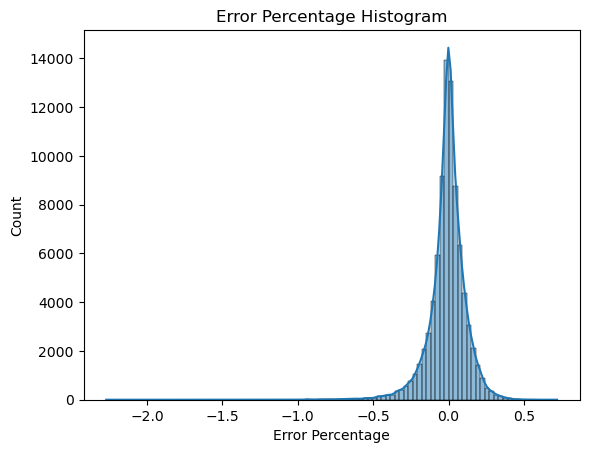

In [43]:
# histogram of errors
sns.histplot(
    X_test,
    x='error_perc',
    bins=100,
    kde=True
)
# addorn
plt.title("Error Percentage Histogram")
plt.xlabel("Error Percentage")
plt.ylabel("Count")
plt.show()

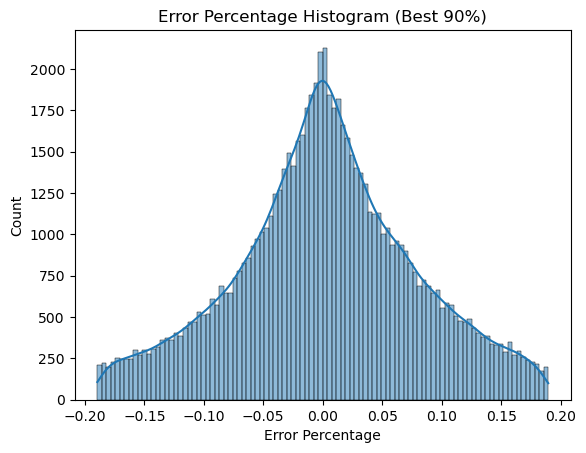

In [44]:
# best 90% histogram
sns.histplot(
    X_test[X_test['error_perc_abs'] <= X_test['error_perc_abs'].quantile(0.9)],
    x='error_perc',
    bins=100,
    kde=True
)
# addorn
plt.title("Error Percentage Histogram (Best 90%)")
plt.xlabel("Error Percentage")
plt.ylabel("Count")
plt.show()

### Categories

In [45]:
# errors for propertytype
(
    X_test
    .groupby('property_type', observed=True)
    .apply(lambda x: calculate_metrics(x['y_true'], x['y_pred'], best_percent=0.9), include_groups=False)
)

rmse      mape          mae        r2
property_type                                              
apartment      2204.663010  0.060714  1312.739398  0.975889
house          1085.644658  0.059714   775.274589  0.942225

In [46]:
# errors for propertytype
(
    X_test
    .groupby('cve_vigilancia_recat', observed=True)
    .apply(lambda x: calculate_metrics(x['y_true'], x['y_pred'], best_percent=0.9), include_groups=False)
)

rmse      mape          mae        r2
cve_vigilancia_recat                                              
0                     1297.838615  0.059766   829.905097  0.969173
1                     1867.970560  0.060820  1221.249565  0.971492

In [47]:
# errors for propertytype
(
    X_test
    .groupby('regimen_propiedad', observed=True)
    .apply(lambda x: calculate_metrics(x['y_true'], x['y_pred'], best_percent=0.9), include_groups=False)
)

rmse      mape          mae        r2
regimen_propiedad                                               
PRIVADA COLECTIVA   1647.684332  0.057798  1021.930064  0.976025
PRIVADA INDIVIDUAL  1068.178019  0.062308   760.876845  0.928362

In [48]:
# errors for id_entidad_f (only get mape)
table_errors_state = (
    X_test
    .groupby('id_entidad_f', observed=True)
    .apply(lambda x: calculate_metrics(x['y_true'], x['y_pred'], best_percent=0.9), include_groups=False)
)
table_errors_state

rmse      mape          mae        r2
id_entidad_f                                              
01             857.299435  0.053920   638.816003  0.924793
02            1313.030624  0.049534   906.201811  0.945875
03            1593.670175  0.069164  1121.958893  0.940554
04            1101.015391  0.080701   876.962433  0.861905
05             741.724614  0.055416   554.039756  0.911005
06            1018.150228  0.062089   752.564109  0.917256
07            1081.808217  0.069399   831.294029  0.748453
08             944.378803  0.059459   704.882701  0.911886
09            4924.628907  0.097967  3563.884526  0.908065
10             639.142117  0.053436   496.922307  0.898160
11             966.482631  0.058376   705.574349  0.923895
12            1837.236593  0.082906  1240.900830  0.941989
13             801.045321  0.050412   611.577989  0.921233
14            1473.231685  0.061295  1000.866118  0.962536
15            1469.638530  0.065358  1012.380656  0.952783
16            1091.298533  0.068918   819.529528  0.912450
17            1599.846280  0.069799  1153.557315  0.873152
18            1331.842564  0.064591   925.868186  0.951725
19             980.042703  0.048157   621.749535  0.973730
20            1118.819931  0.066206   883.216722  0.815876
21            1193.310258  0.064960   870.728389  0.915910
22            1270.530312  0.057203   965.246555  0.919258
23            1321.650178  0.045746   800.704902  0.975003
24            1035.756601  0.062819   786.284254  0.906111
25            1321.542046  0.066145   950.895118  0.944674
26             960.012526  0.059220   701.966974  0.939535
27            1173.200413  0.078115   909.828550  0.891956
28             632.235809  0.045248   457.773001  0.930120
29             708.234581  0.056141   523.848968  0.823683
30            1063.065324  0.070855   807.617010  0.863903
31             853.397519  0.047725   584.484320  0.954443
32             816.401885  0.053852   597.380027  0.891450

In [49]:
# see error upfront_beach of beach vs not infront of beach
(
    X_test
    .query("distance_to_ocean.lt(100_000)")
    .groupby('distance_to_ocean', observed=True)
    .apply(lambda x: calculate_metrics(x['y_true'], x['y_pred'], best_percent=0.9), include_groups=False)
)

rmse      mape          mae        r2
distance_to_ocean                                              
500.0              4721.302027  0.113454  2892.076854  0.916884
2000.0             2244.547731  0.085344  1458.796382  0.954116
10000.0            1171.792621  0.055746   805.850233  0.962183
50000.0             941.679323  0.055044   670.124750  0.943716

## Temporal Error

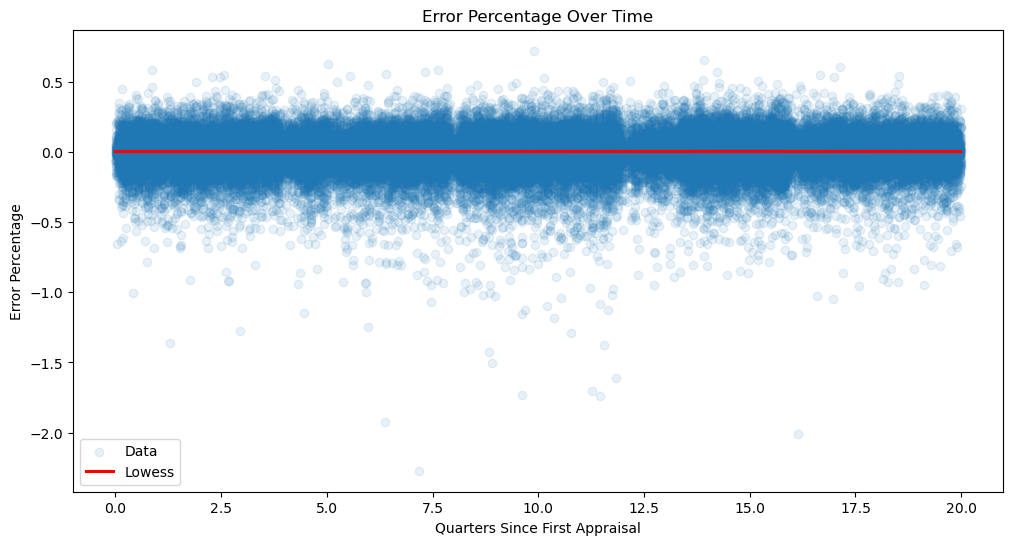

In [50]:
# visualize errors over time
fig, ax = plt.subplots(figsize=(12, 6))

sns.regplot(
    x='quarters_since_first_appraisal',
    y='error_perc',
    data=X_test,
    scatter_kws={'alpha': 0.1},
    line_kws={'color': 'red'},
    ax=ax,
    lowess=True
)

# addorn
plt.title("Error Percentage Over Time")
plt.xlabel("Quarters Since First Appraisal")
plt.ylabel("Error Percentage")

# add legend
plt.legend(['Data', 'Lowess'])

plt.show()

In [51]:
# adjust linear regression to error_perc
lm_time_error = smf.ols('error_perc ~ quarters_since_first_appraisal', data=X_test).fit()

# see summary
lm_time_error.summary()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             error_perc   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                 0.0004998
Date:                Tue, 23 Jul 2024   Prob (F-statistic):              0.982
Time:                        15:29:46   Log-Likelihood:                 57072.
No. Observations:               85292   AIC:                        -1.141e+05
Df Residuals:                   85290   BIC:                        -1.141e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -0.0075      0.001     -9.019      0.000      -0.009      -0.006
quarters_since_first_appraisal  1.697e-06   7.59e-05      0.022      0.982      -0.000       0.000
==============================================================================
Omnibus:                    33964.176   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           505246.556
Skew:                          -1.514   Prob(JB):                         0.00
Kurtosis:                      14.533   Cond. No.                         21.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Geospatial Error

Text(0.5, 1.0, 'MAPE by state')

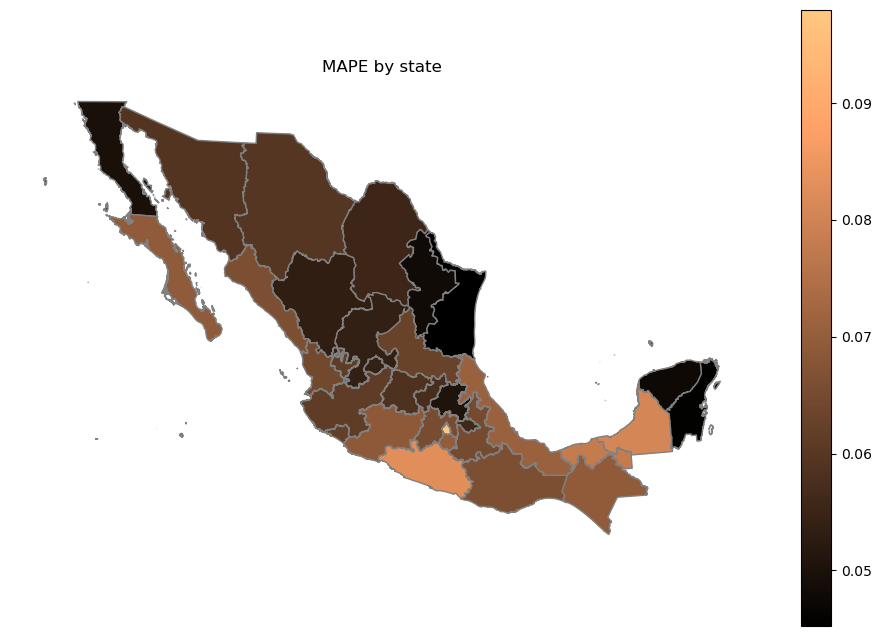

In [52]:
# plot MAPE by state
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

(
    gdf_mexico
    .merge(
        table_errors_state.reset_index(),
        left_on='cvegeo',
        right_on='id_entidad_f',
        how='left'
    )
    .plot('mape', legend=True, ax=ax, cmap='copper', edgecolor='gray')
)

# dont show axis
plt.axis('off')

# title
plt.title('MAPE by state')

## Covariates


In [53]:
def visualize_errors(df, col):
    # visualize errors over time
    fig, ax = plt.subplots(figsize=(12, 6))

    sns.regplot(
        x=col,
        y='error_perc',
        data=df,
        scatter_kws={'alpha': 0.1},
        line_kws={'color': 'red'},
        ax=ax,
        lowess=True
    )

    # addorn
    plt.title(f"Error Percentage by {col}")
    plt.xlabel(col)
    plt.ylabel("Error Percentage")

    # add legend
    plt.legend(['Data', 'Lowess'])

    plt.show()
    return

/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


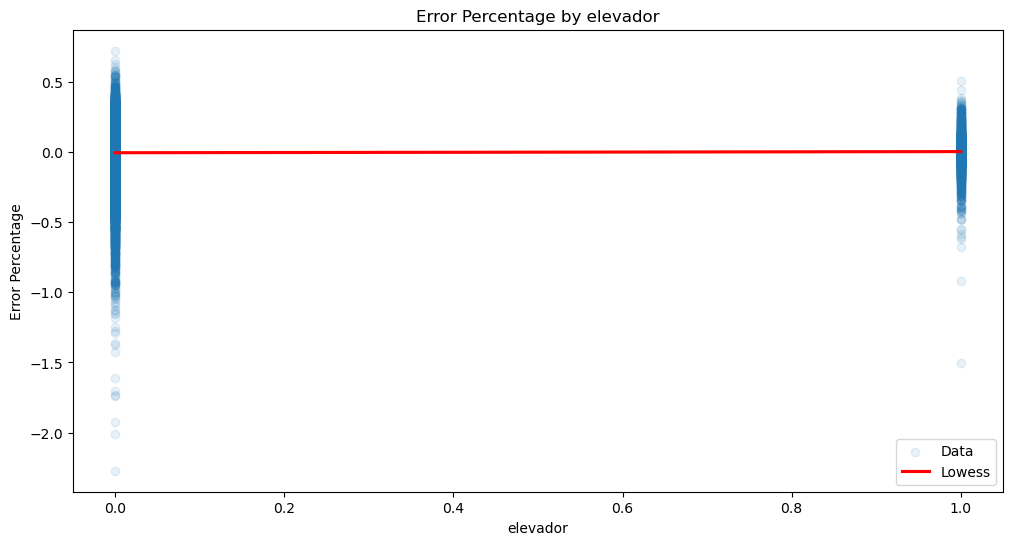

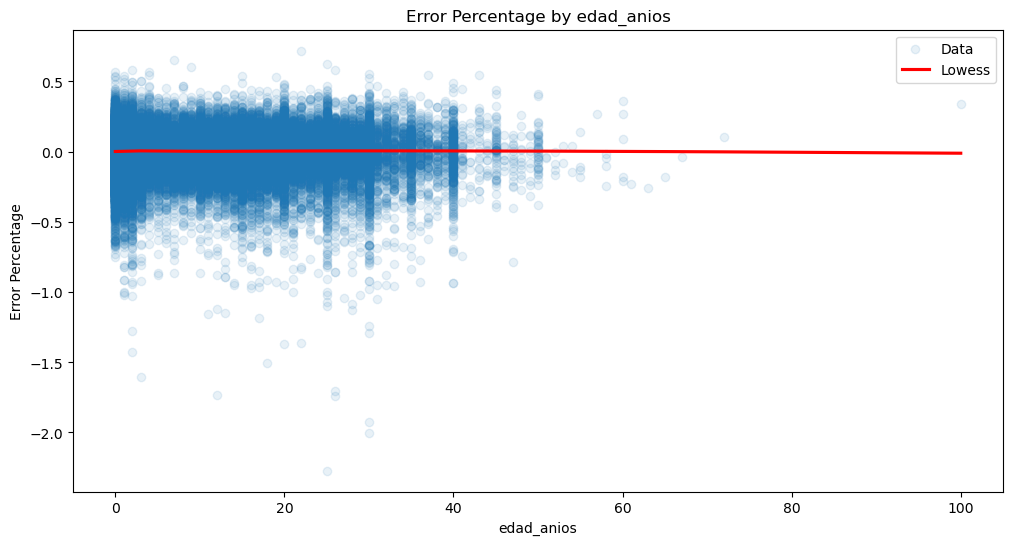

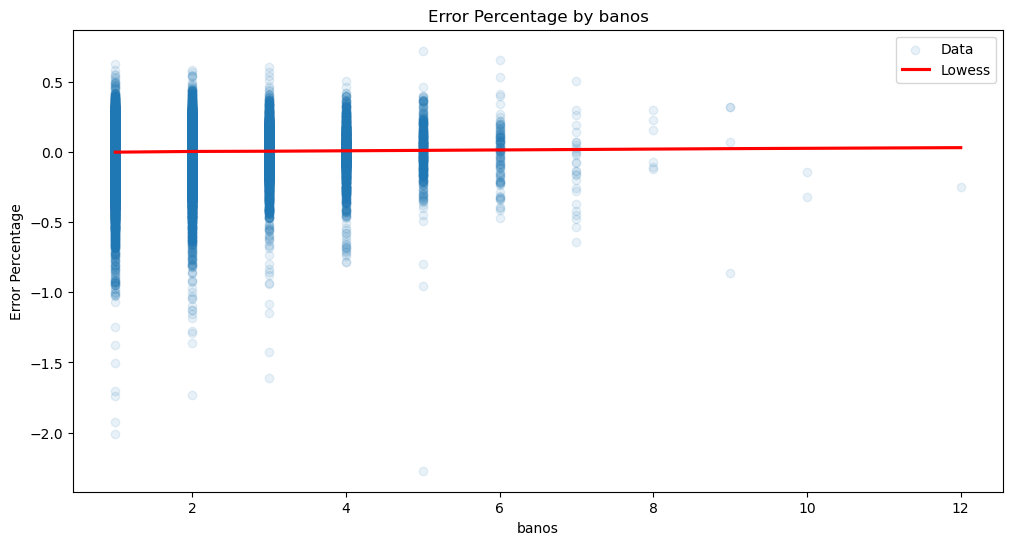

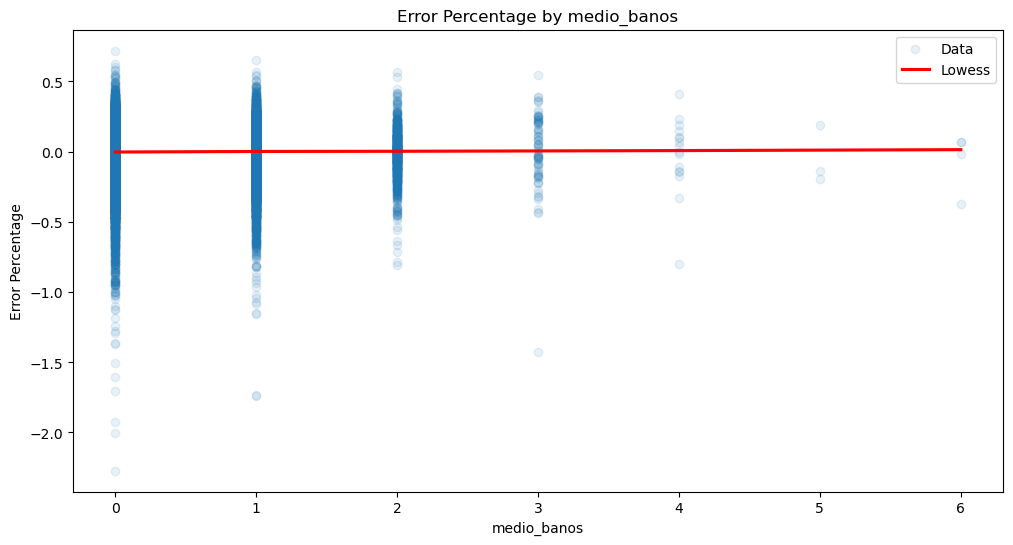

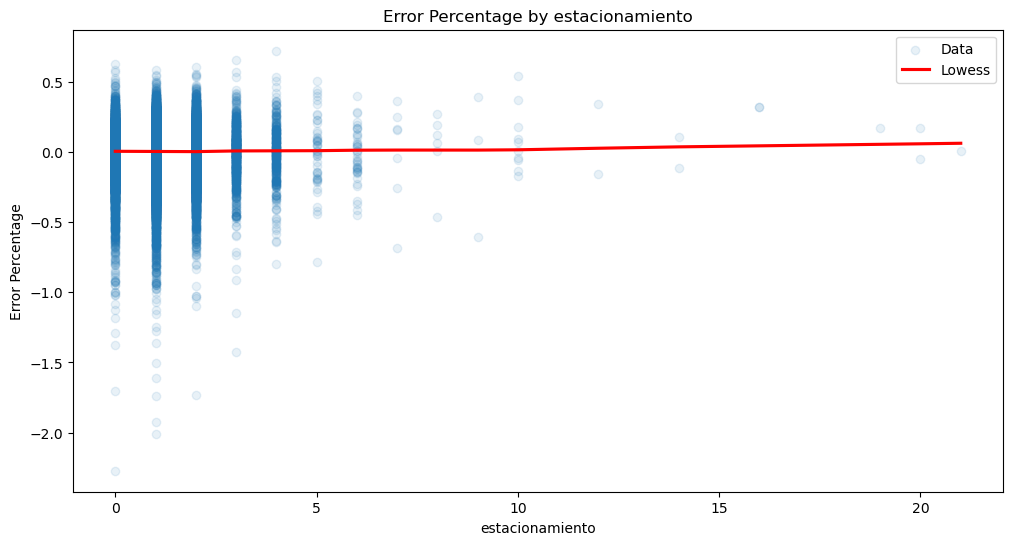

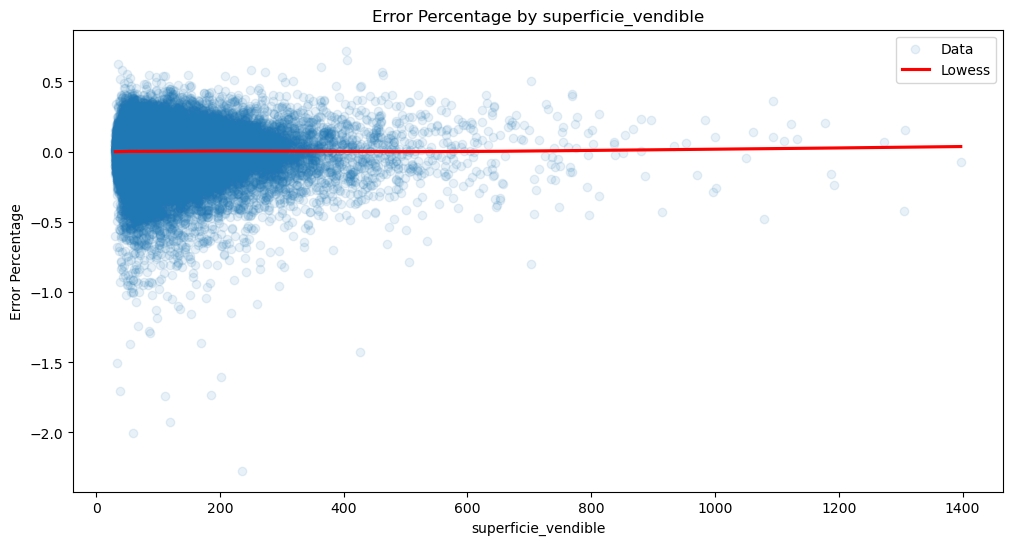

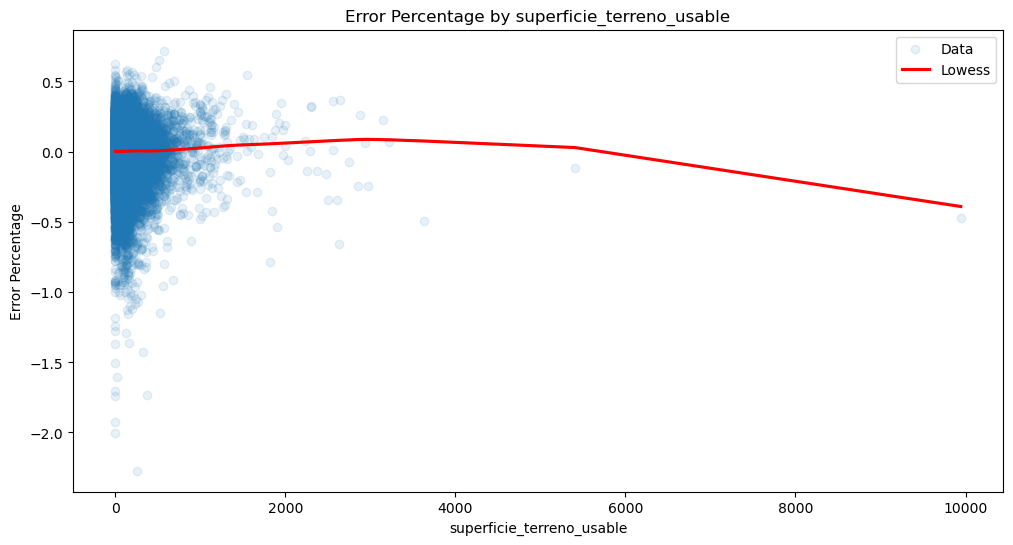

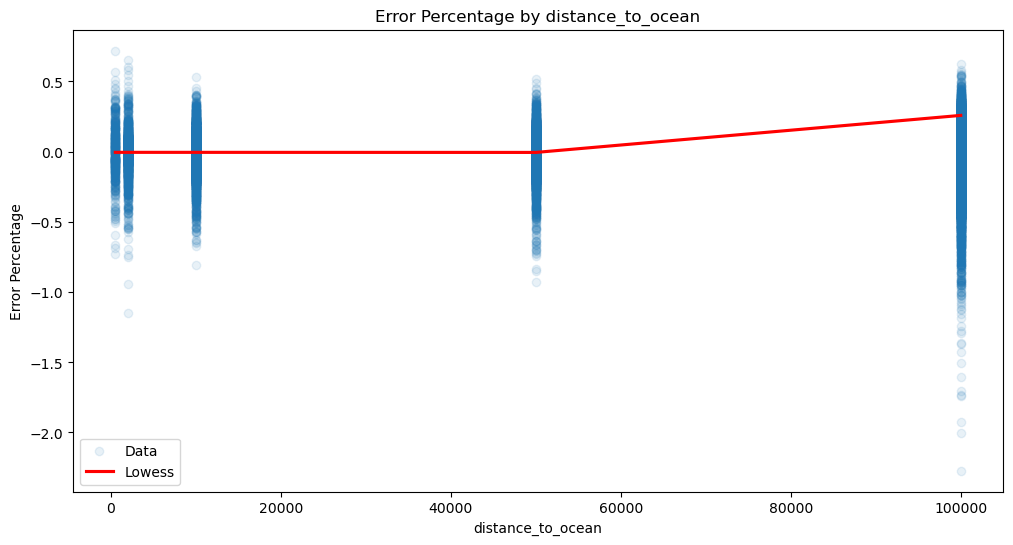

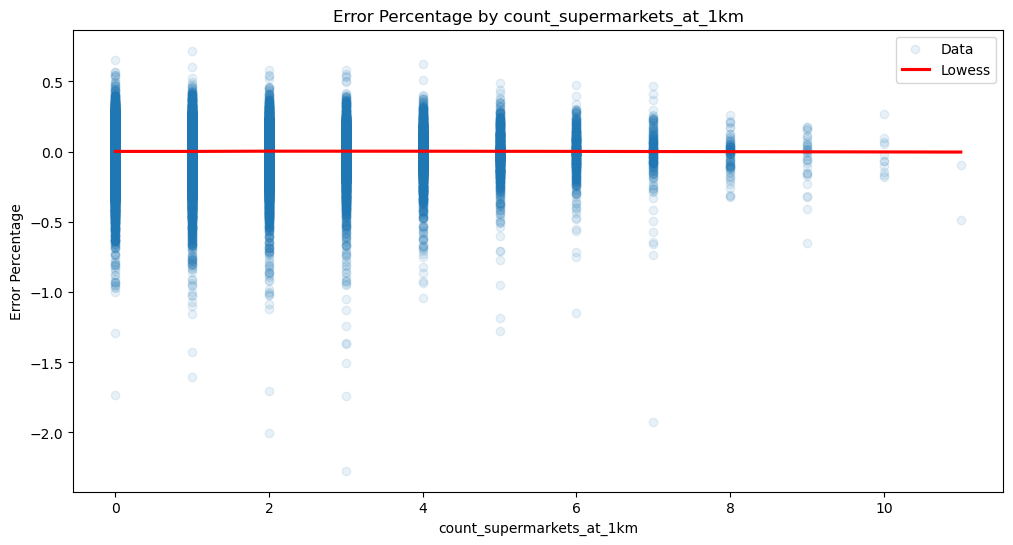

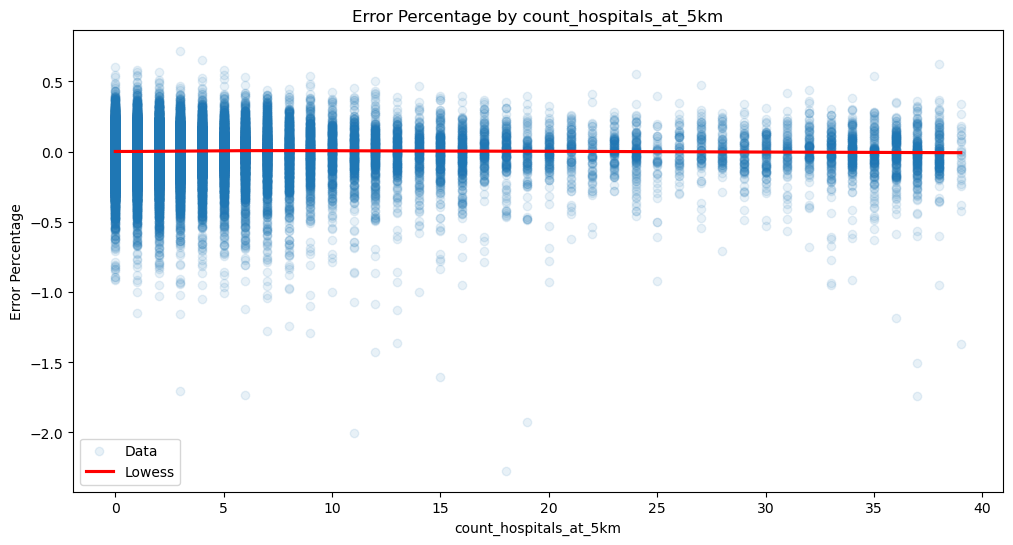

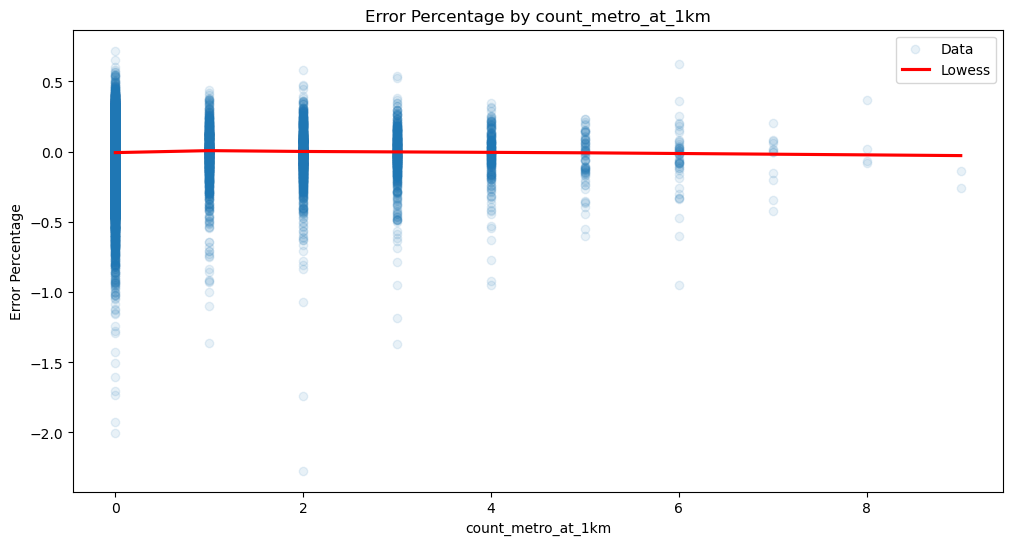

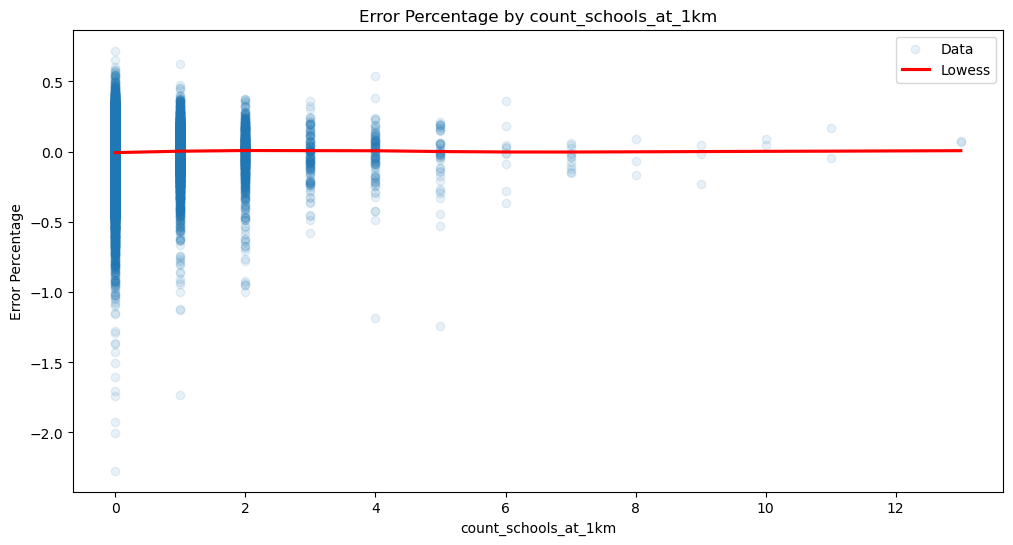

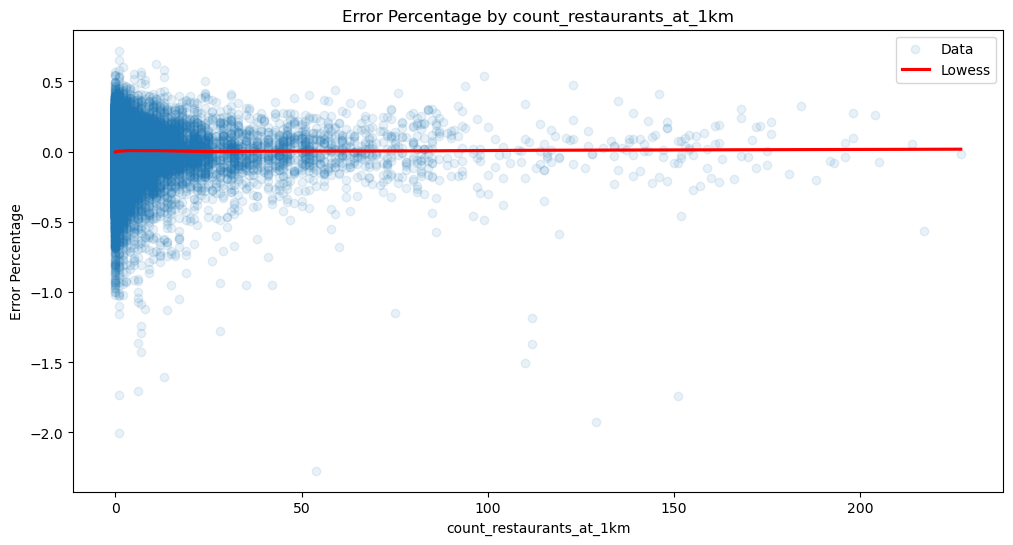

TypeError: Categorical is not ordered for operation min
you can use .as_ordered() to change the Categorical to an ordered one


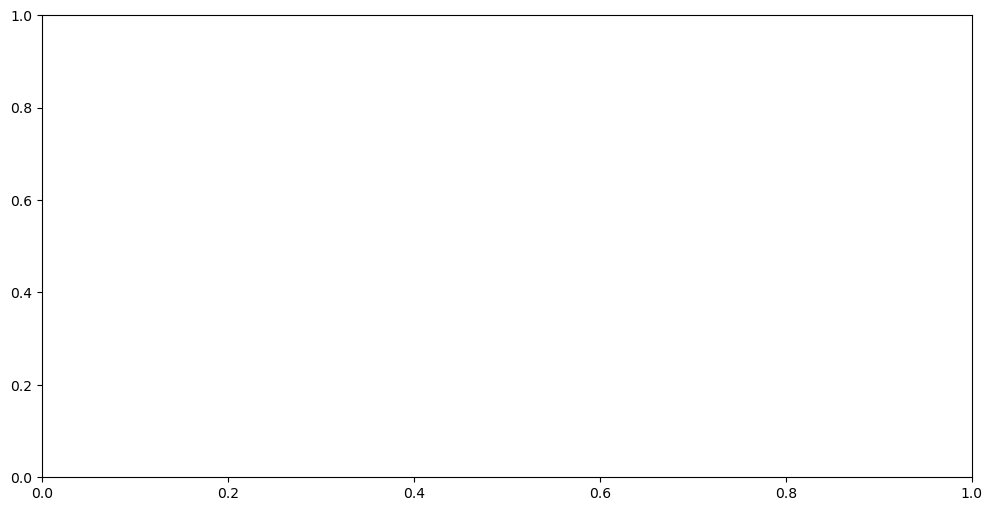

In [54]:
# visualize errors by categories
cols_x = [
    'elevador',
    'edad_anios',
    'banos',
    'medio_banos',
    'estacionamiento',
    'superficie_vendible',
    'superficie_terreno_usable',
    'distance_to_ocean',
    'count_supermarkets_at_1km',
    'count_hospitals_at_5km',
    'count_metro_at_1km',
    'count_schools_at_1km',
    'count_restaurants_at_1km',
    # 'competitors_weighted_mean_log_price_per_sqm',
    # 'mean_log_valor_fisico_terreno_m2',
    # 'mean_log_valor_fisico_terreno_m2_lower',
    # 'mean_log_valor_fisico_terreno_m2_upper',
    # 'quarters_since_first_appraisal', 
    'cve_vigilancia_recat'
]

for col in cols_x:
    visualize_errors(X_test, col)

---
# Feature Importance

## General Importance

In [55]:
## Feature Importance
explainer = shap.TreeExplainer(best_model)

# calculate shap values
cols_x = [
    'id_clase_inmueble', 
    'property_type',
    'elevador', 'edad_anios',
    'regimen_propiedad', 'id_entidad_f', 'banos',
    'medio_banos', 'estacionamiento', 'superficie_vendible',
    'superficie_terreno_usable', 'distance_to_ocean', 'longitud', 'latitud',
    'count_supermarkets_at_1km', 'count_hospitals_at_5km',
    'count_metro_at_1km', 'count_schools_at_1km',
    'count_restaurants_at_1km',
    'competitors_weighted_mean_log_price_per_sqm',
    'mean_log_valor_fisico_terreno_m2',
    'mean_log_valor_fisico_terreno_m2_lower',
    'mean_log_valor_fisico_terreno_m2_upper',
    'quarters_since_first_appraisal', 'conservacion_recat',
    'cve_vigilancia_recat'
]
shap_values = explainer(X_test.loc[:, cols_x])

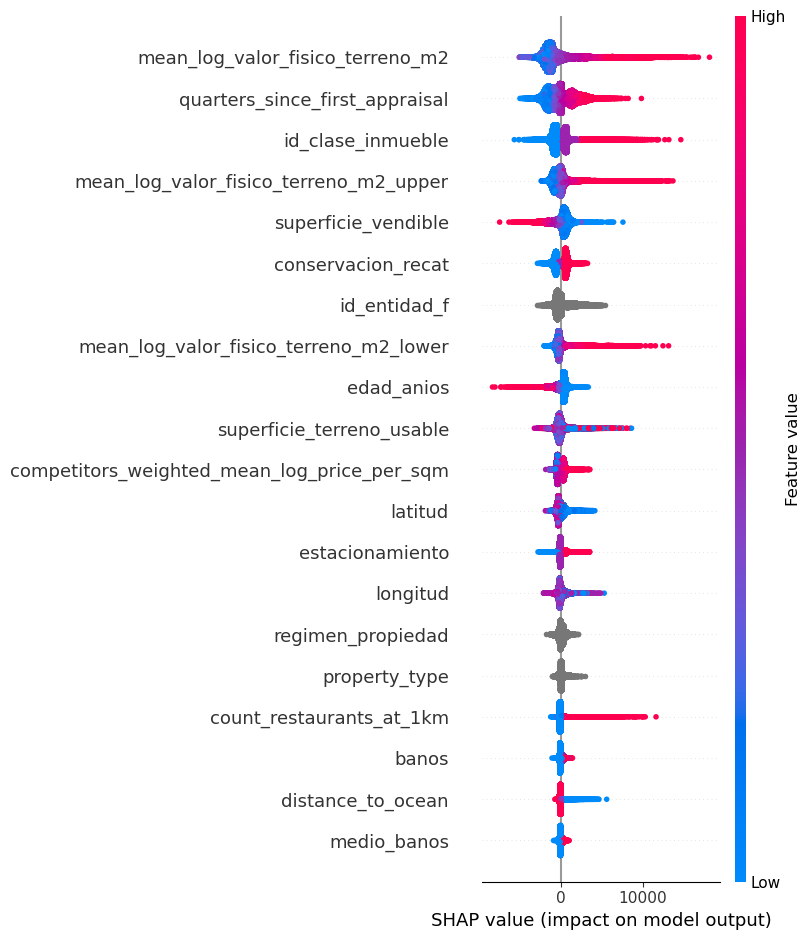

In [56]:
# plot feature importance
shap.summary_plot(shap_values, X_test.loc[:, cols_x])

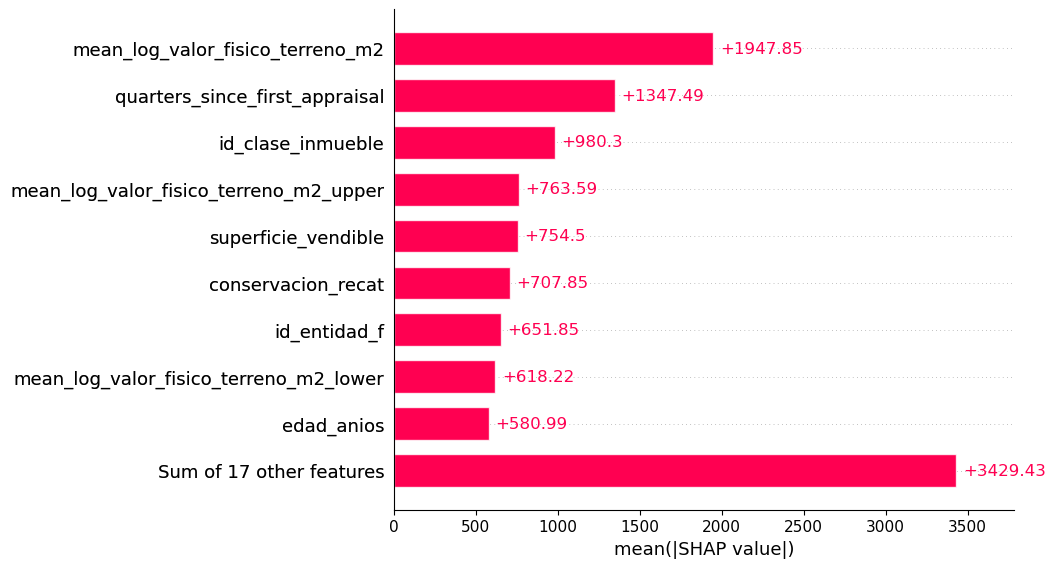

In [57]:
# plot feature importance
shap.plots.bar(shap_values, max_display=10)

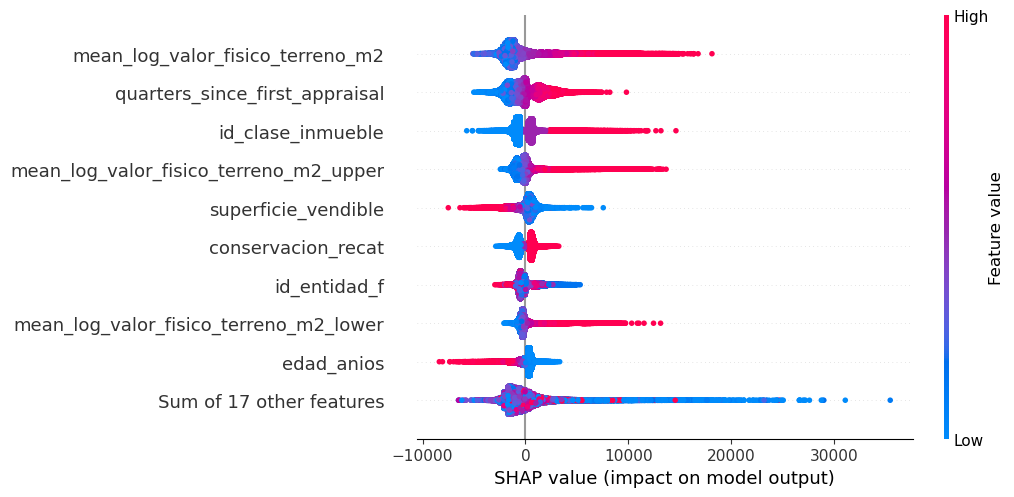

In [58]:
# Plot a beeswarm plot of SHAP values
shap.plots.beeswarm(shap_values, max_display=10)

## Interactions

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


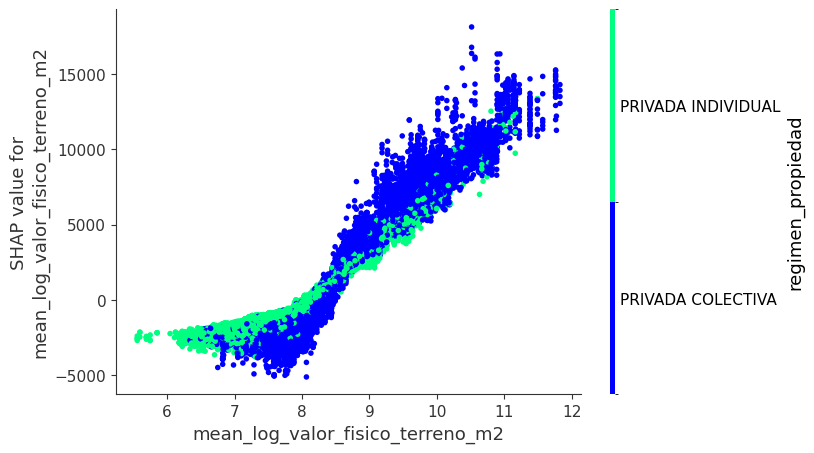

In [59]:
# partal dependence plot
shap.dependence_plot('mean_log_valor_fisico_terreno_m2', shap_values.values, X_test.loc[:, cols_x], cmap=plt.get_cmap("winter"))

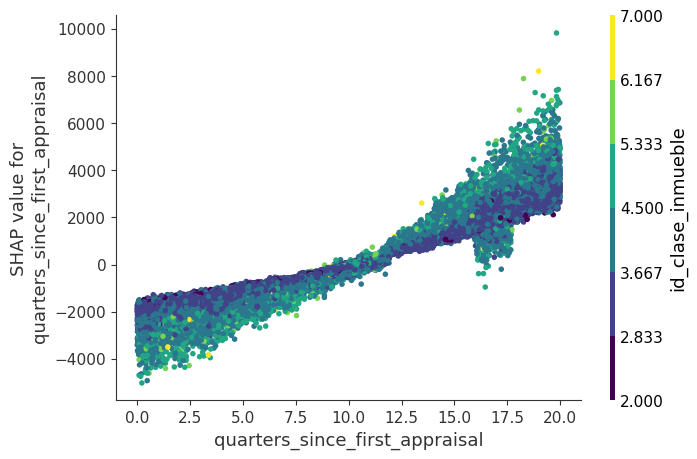

In [60]:
# partal dependence plot
shap.dependence_plot('quarters_since_first_appraisal', shap_values.values, X_test.loc[:, cols_x], interaction_index='id_clase_inmueble', cmap=plt.get_cmap("viridis"))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


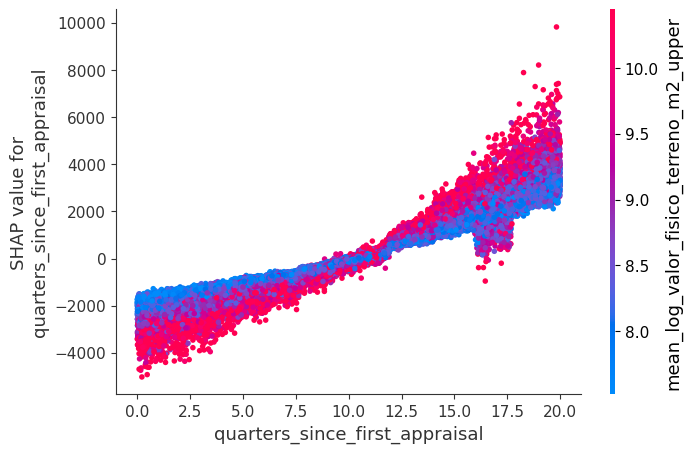

In [61]:
# partal dependence plot
shap.dependence_plot('quarters_since_first_appraisal', shap_values.values, X_test.loc[:, cols_x])

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


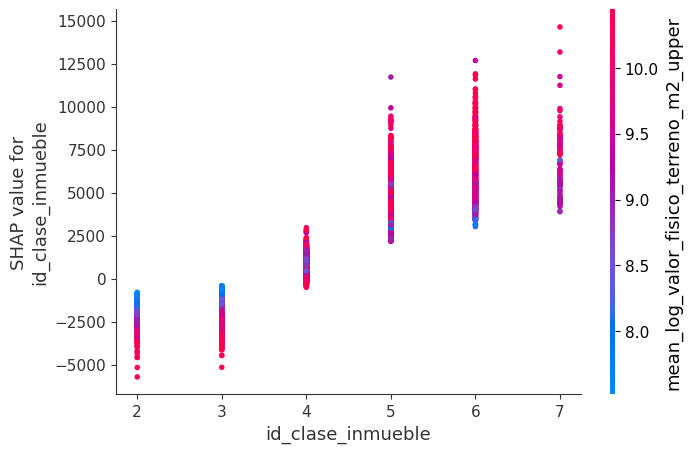

In [62]:
# partal dependence plot
shap.dependence_plot('id_clase_inmueble', shap_values.values, X_test.loc[:, cols_x])

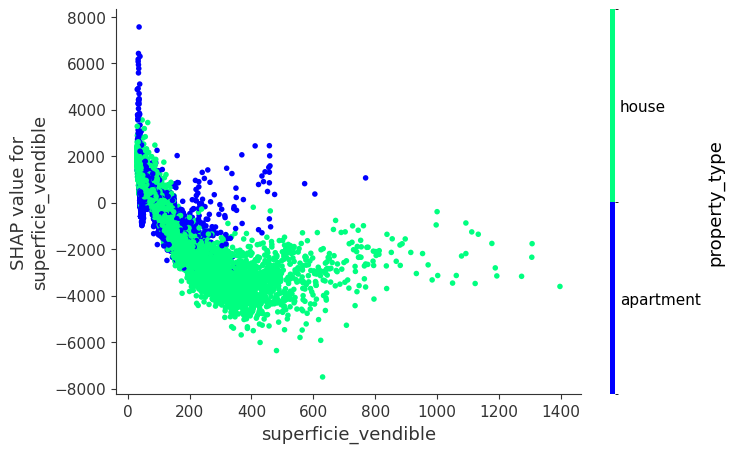

In [63]:
# partal dependence plot
shap.dependence_plot('superficie_vendible', shap_values.values, X_test.loc[:, cols_x], interaction_index='property_type', cmap=plt.get_cmap("winter"))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


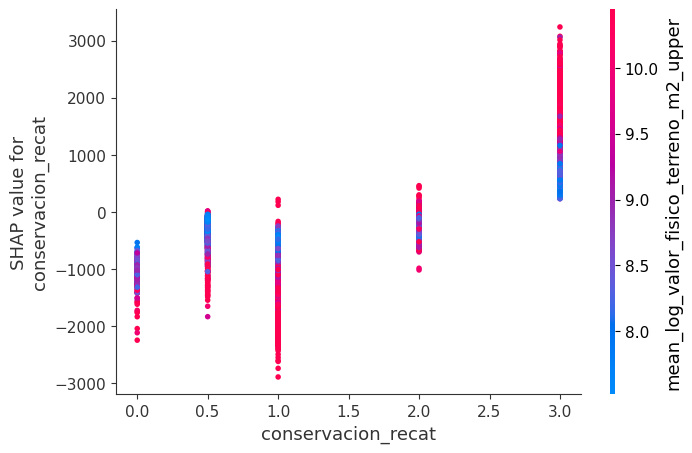

In [64]:
# partal dependence plot
shap.dependence_plot('conservacion_recat', shap_values.values, X_test.loc[:, cols_x])

^^^maybe my categorization of remodeled is not good (move 1 position more)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


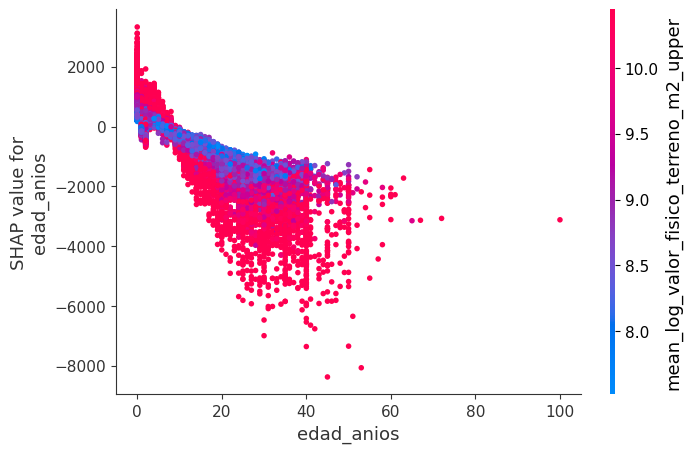

In [65]:
# partal dependence plot
shap.dependence_plot('edad_anios', shap_values.values, X_test.loc[:, cols_x])

---
# Sandbox

In [ ]:
X_test.columns

Index(['id_clase_inmueble', 'property_type', 'elevador', 'edad_anios',
       'regimen_propiedad', 'id_entidad_f', 'banos', 'medio_banos',
       'estacionamiento', 'superficie_vendible', 'superficie_terreno_usable',
       'distance_to_ocean', 'longitud', 'latitud', 'count_supermarkets_at_1km',
       'count_hospitals_at_5km', 'count_metro_at_1km', 'count_schools_at_1km',
       'count_restaurants_at_1km',
       'competitors_weighted_mean_log_price_per_sqm',
       'mean_log_valor_fisico_terreno_m2',
       'mean_log_valor_fisico_terreno_m2_lower',
       'mean_log_valor_fisico_terreno_m2_upper',
       'quarters_since_first_appraisal', 'conservacion_recat',
       'cve_vigilancia_recat', 'y_pred', 'y_true', 'error', 'error_perc',
       'error_perc_abs'],
      dtype='object')

In [ ]:
df_properties.columns

Index(['id_clase_inmueble', 'property_type', 'elevador', 'edad_anios',
       'year_appraised', 'regimen_propiedad', 'id_entidad_f', 'banos',
       'medio_banos', 'estacionamiento', 'superficie_vendible',
       'superficie_terreno_usable', 'distance_to_ocean', 'longitud', 'latitud',
       'count_supermarkets_at_1km', 'count_hospitals_at_5km',
       'count_metro_at_1km', 'count_schools_at_1km',
       'count_restaurants_at_1km',
       'competitors_weighted_mean_log_price_per_sqm',
       'mean_log_valor_fisico_terreno_m2',
       'mean_log_valor_fisico_terreno_m2_lower',
       'mean_log_valor_fisico_terreno_m2_upper',
       'quarters_since_first_appraisal', 'conservacion_recat',
       'cve_vigilancia_recat', 'price_per_sqm'],
      dtype='object')